### Phase 2 — Image Feature Engineering via Residual Learning

Train a convolutional neural network (ResNet-18) on satellite imagery to learn **visual residuals** not captured by tabular features. The CNN is optimized to predict the residual error of a strong tabular model, enabling it to focus on environmental and neighborhood context.

#### Key Steps
- Train a tabular baseline model (XGBoost)
- Compute residuals between true price and tabular predictions
- Fine-tune a pretrained ResNet-18 on satellite images to predict residuals
- Extract high-dimensional image embeddings for downstream multimodal experiments
- Save trained CNN and associated metadata

#### Output
- Trained residual image model (`residual_cnn.pt`)
- Image embeddings for multimodal fusion experiments
- Saved tabular model and scaler


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_PATH = "..data/processed/train_clean.csv"
IMAGE_DIR = "..data/processed/images"
OUTPUT_DIR = "..data/processed"

BATCH_SIZE = 32
NUM_WORKERS = 2

In [4]:
df = pd.read_csv(DATA_PATH)
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,lat,long,sqft_living15,sqft_lot15,log_price,size_quality,living_density_ratio
0,9117000170,4,2.25,1810,9240,2.0,0,0,3,7,47.4362,-122.187,1660,9240,12.501142,12670,1.089705
1,6700390210,3,2.50,1600,2788,2.0,0,0,4,7,47.4034,-122.187,1720,3605,12.409018,11200,0.929692
2,7212660540,4,2.50,1720,8638,2.0,0,0,3,8,47.2704,-122.313,1870,7455,12.206078,13760,0.919294
3,8562780200,2,2.25,1240,705,2.0,0,0,3,7,47.5321,-122.073,1240,750,12.772806,8680,0.999194
4,7760400350,3,2.00,1280,13356,1.0,0,0,3,7,47.3715,-122.074,1590,8071,12.354497,8960,0.804525


In [5]:
def image_exists(pid):
    pid = str(int(pid))
    return os.path.exists(os.path.join(IMAGE_DIR, f"{pid}.0.png"))

df = df[df["id"].apply(image_exists)].reset_index(drop=True)

print("Remaining properties:", len(df))

Remaining properties: 16208


In [6]:
TABULAR_FEATURES = [
    'bedrooms','bathrooms','sqft_living','sqft_lot',
    'floors','condition','grade','waterfront',
    'view','sqft_living15','sqft_lot15','lat','long',
    'size_quality',	'living_density_ratio'
]

X_tab = df[TABULAR_FEATURES].values
y = df['log_price'].values

scaler = StandardScaler()
X_tab = scaler.fit_transform(X_tab)

tab_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

tab_model.fit(X_tab, y)

df['residual'] = y - tab_model.predict(X_tab)
df['residual'].describe()

,residual
count,16208.000000
mean,-0.000041
std,0.116892
min,-0.979957
25%,-0.061852
50%,0.004851
75%,0.067992
max,0.728000


In [7]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:
class ResidualImageDataset(Dataset):
    def __init__(self, df, image_dir, transform):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = int(self.df.loc[idx, "id"])
        img_path = os.path.join(self.image_dir, f"{pid}.0.png")

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        residual = torch.tensor(
            self.df.loc[idx, "residual"],
            dtype=torch.float32
        )

        return image, residual

In [9]:
dataset = ResidualImageDataset(df, IMAGE_DIR, image_transform)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

len(dataloader)

507

In [10]:
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights)

resnet18.fc = nn.Identity()

for name, param in resnet18.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet18 = resnet18.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [11]:
class ResidualImageModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.regressor = nn.Linear(512, 1)

    def forward(self, x):
        feat = self.backbone(x)
        out = self.regressor(feat)
        return out.squeeze(), feat

In [12]:
model = ResidualImageModel(resnet18).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()


In [13]:
EPOCHS = 7
model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for images, targets in tqdm(dataloader):
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        preds, _ = model(images)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss/len(dataloader):.4f}")

  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 0.0397


  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.0140


  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.0095


  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.0088


  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.0070


  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.0063


  0%|          | 0/507 [00:00<?, ?it/s]

Epoch 7/7 | Loss: 0.0059


In [14]:
model.eval()

all_embeddings = []
all_ids = []

with torch.no_grad():
    for images, _ in tqdm(dataloader):
        images = images.to(DEVICE, non_blocking=True)
        _, feats = model(images)
        all_embeddings.append(feats.cpu().numpy())

image_embeddings = np.vstack(all_embeddings)
image_ids = df['id'].values

  0%|          | 0/507 [00:00<?, ?it/s]

In [15]:
np.save(os.path.join(OUTPUT_DIR, "image_embeddings.npy"), image_embeddings)
np.save(os.path.join(OUTPUT_DIR, "image_ids.npy"), image_ids)

print("Embeddings shape:", image_embeddings.shape)

Embeddings shape: (16208, 512)


In [16]:
np.isnan(image_embeddings).any(), np.isinf(image_embeddings).any()

(np.False_, np.False_)

In [17]:
image_embeddings.std(axis=0).mean()

np.float32(0.2246679)

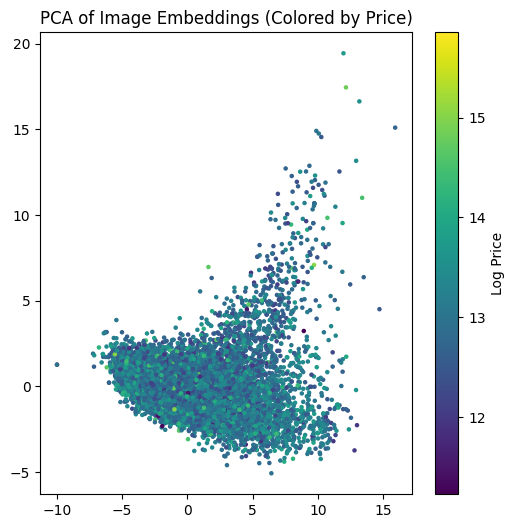

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(image_embeddings)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1],
            c=df['log_price'], cmap='viridis', s=5)
plt.colorbar(label="Log Price")
plt.title("PCA of Image Embeddings (Colored by Price)")
plt.show()

In [ ]:
import joblib

TAB_MODEL_PATH = os.path.join(OUTPUT_DIR, "tabular_xgb.json")
tab_model.save_model(TAB_MODEL_PATH)

SCALER_PATH = os.path.join(OUTPUT_DIR, "tabular_scaler.joblib")
joblib.dump(scaler, SCALER_PATH)

MODEL_PATH = os.path.join(OUTPUT_DIR, "residual_cnn.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "backbone": "resnet18",
    "epochs": EPOCHS,
    "optimizer_state_dict": optimizer.state_dict()
}, MODEL_PATH)